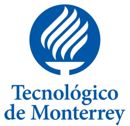

# **Maestría en Inteligencia Artificial Aplicada**
## **Curso: Estrategia de implementación de servicios tecnológicos**
### Tecnológico de Monterrey
### Prof Luis Eduardo Falcón Morales

## **6.3 Actividad**
## Actividad en Equipos - Semanas 6 y 7:

### **Modelado de Tópicos - LSI/LDA**
____________

## Equipo 12
> - Francisco Javier Parga Garcia  **A01794380**
>
> - Enrique Hernández García **A01793727**
>
> - Matthias Sibrian Illescas **A01794249**
>
> - Alejandro Tomás Mackey **A01164338**
>
> - Ignacio Valdés Reyes **A0179326**




# 0. Librerias¶

In [2]:
!pip install -q nltk
!pip install -q langdetect
!pip install -q spacy
!python -m spacy download es_core_news_sm


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 12.9/12.9 MB 3.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import re
import nltk
import spacy
import pandas as pd
import ipywidgets as widgets
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords


nltk.download('stopwords')
nltk.download('punkt')

c:\Users\matth\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\matth\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1. Carga del dato

In [4]:
# Descargar y cargar el modelo de spaCy para español
nlp = spacy.load('es_core_news_sm')

# Cargar el archivo y crear el DataFrame
with open('noticiasTopicModeling.txt', 'r', encoding='utf-8') as file:
    noticias = eval(file.read())  # Cargar el contenido del archivo como una lista de diccionarios

df = pd.DataFrame(noticias)
df.head()

,titular,texto
0,Vox se sube a la ola de la extrema derecha eur...,"""España ha dejado de ser católica"", decía Manu..."
1,Mensajes xenófobos de Vox y la cancelación de ...,El clima de crispación social en Ceuta ha lleg...
2,El Gobierno alega el estado de alarma para no ...,El Gobierno ha alegado la suspensión de plazos...
3,La fiscala,"Puedes mandar tu pregunta, sugerencia o queja ..."
4,La CorteIDH pide a Panamá informe sobre migran...,Panamá debe entregar esta semana a la Corte In...


# 2. Limpieza del texto

In [5]:
df['texto'] = df['texto'].apply(lambda x: re.sub(r'[^\w\s]', '', x))  # Eliminar signos de puntuación

# Realizar el preprocesamiento de texto
stop_words = set(stopwords.words('spanish'))

preprocessed_text = []
preprocessed_tokens = []
for text in tqdm(df['texto']):
    text = text.lower()
    doc = nlp(text)
    filtered_tokens = [token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words]
    preprocessed_text.append(' '.join(filtered_tokens))
    preprocessed_tokens.append(filtered_tokens)

df['noticia'] = preprocessed_text
df.head()

  0%|          | 0/5658 [00:00<?, ?it/s]

,titular,texto,noticia
0,Vox se sube a la ola de la extrema derecha eur...,España ha dejado de ser católica decía Manuel ...,españa haber dejar ser católico decir manuel a...
1,Mensajes xenófobos de Vox y la cancelación de ...,El clima de crispación social en Ceuta ha lleg...,clima crispación social ceuta haber llegar pun...
2,El Gobierno alega el estado de alarma para no ...,El Gobierno ha alegado la suspensión de plazos...,gobierno haber alegar suspensión plazo derivad...
3,La fiscala,Puedes mandar tu pregunta sugerencia o queja a...,poder mandar pregunta sugerencia queja través ...
4,La CorteIDH pide a Panamá informe sobre migran...,Panamá debe entregar esta semana a la Corte In...,panamá deber entregar semana corte interameric...


# 3. ¿Por qué en este caso no requerimos hacer una partición en entrenamiento, validación y prueba?

Porque es una tarea no supervisada de aprendizaje automático.

En el aprendizaje supervisado, separamos nuestros datos en conjuntos de entrenamiento, validación y prueba para poder entrenar nuestro modelo, ajustarlo y evaluarlo.

Sin embargo, en el modelado de temas (aprendizaje no supervisado), nuestro objetivo no es predecir, es encontrar patrones o estructuras en los datos; por ejemplo: los "temas" que aparecen en los textos de las noticias.

# 4. Matriz Tf-idf 

In [6]:
# Calcular la matriz Tf-idf
vectorizer = TfidfVectorizer(min_df=10)
tfidf_matrix = vectorizer.fit_transform(df['noticia'])

# Obtener los nombres de las características y eliminar las columnas que no son palabras en español
feature_names = vectorizer.get_feature_names_out()
keep_columns = []

for col in tqdm(range(tfidf_matrix.shape[1])):
    token = feature_names[col]
    doc = nlp(token)
    if doc.has_vector:
        keep_columns.append(col)

tfidf_matrix = tfidf_matrix[:, keep_columns]
feature_names = [feature_names[col] for col in keep_columns]

# Crear el DataFrame con los valores de Tf-idf
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
display(df_tfidf.head())

  0%|          | 0/12384 [00:00<?, ?it/s]

,abad,abadía,abajo,abanderar,abandonado,abandonar,abandono,abanico,abaratar,abarcar,...,órdago,órden,órgano,óscar,últimamente,último,única,únicamente,único,útil
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.017003,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.019957,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.026999,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.013087,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


## ¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?

> Cada renglón de la matriz corresponde a un documento (una noticia) y cada columna corresponde a una palabra (una característica). El valor de cada celda es el peso Tf-idf de esa palabra en ese documento. Un valor alto significa que la palabra es relevante para el documento, y un valor bajo significa que la palabra es común o irrelevante.

# 5.  Descomposición de valores singulares truncado a la matriz Tf-idf

In [7]:
# Se define el objeto que aplicará SVD truncada con r valores singulares:

r = 10    # Máxima cantidad de valores singulares a considerar --> tópicos a generar:

lsi_obj = TruncatedSVD(n_components = r, 
                       n_iter=100,  # número de iteraciones ... recordemos que es un método iterativo.
                       random_state=42) 

tfidf_lsi = lsi_obj.fit_transform(tfidf_matrix)    # ndarray: se ajusta y aplica la SVD truncada.


Sigma = lsi_obj.singular_values_     # ndarray_(r,)

V_T = lsi_obj.components_.T         # ndarray_(n_terms X r)  
                                    # Las r columnas son los r temas/topics generados
                                    # Se ordenan los n_terms/words de mayor a menor para 
                                    # obtener las keywords principales de cada tópico.
sigmas = lsi_obj.singular_values_
sigmas

array([21.17520684,  8.26250446,  7.43695651,  6.28126533,  6.20018397,
        6.1208386 ,  5.92187604,  5.39331773,  5.31562696,  5.22545533])

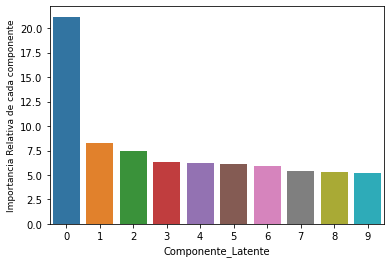

In [8]:
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma )
chart.set_xlabel('Componente_Latente', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada componente', fontdict={'size': 9})
plt.show()

# 6. Matriz tokens-temas (term-topic) a partir de la matriz $𝑉^{T}$ de la descomposición SVD

In [9]:
lsi_term_topic = V_T 

# rescatemos los nombres de los términos/tokens:

term_names = feature_names

print(term_names[:19])

['abad', 'abadía', 'abajo', 'abanderar', 'abandonado', 'abandonar', 'abandono', 'abanico', 'abaratar', 'abarcar', 'abarrotado', 'abascal', 'abastecer', 'abastecimiento', 'abasto', 'abatido', 'abatir', 'abc', 'abdicación']


In [10]:
# Y generamos un DataFrame con la matriz term-topic:

term_topic_matrix = pd.DataFrame(data=lsi_term_topic, 
                                 index = term_names,   
                                 columns = [f'Concepto_Latente_{r}' for r in range(0,V_T.shape[1])]
                                )

print(term_topic_matrix.shape)   #  words X topics
term_topic_matrix.head()

(12384, 10)


,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
abad,0.000814,-0.000969,-0.000577,0.001257,0.000369,0.000111,-0.000527,0.000019,0.000630,-0.000382
abadía,0.000513,-0.001006,-0.000514,0.000280,-0.000060,0.000146,0.000653,-0.000138,-0.000369,-0.000625
abajo,0.002840,-0.001832,-0.005737,0.000790,-0.000399,0.001048,-0.001765,0.001599,-0.000037,0.001866
abanderar,0.000567,-0.001264,0.000690,-0.001096,-0.000316,0.000765,-0.000080,-0.000641,0.000280,-0.000526
abandonado,0.002193,-0.000700,-0.003721,0.000895,-0.001372,-0.000035,-0.000231,0.000267,0.001114,-0.000325


# 7 y 8. Gráficos de conceptos latentes

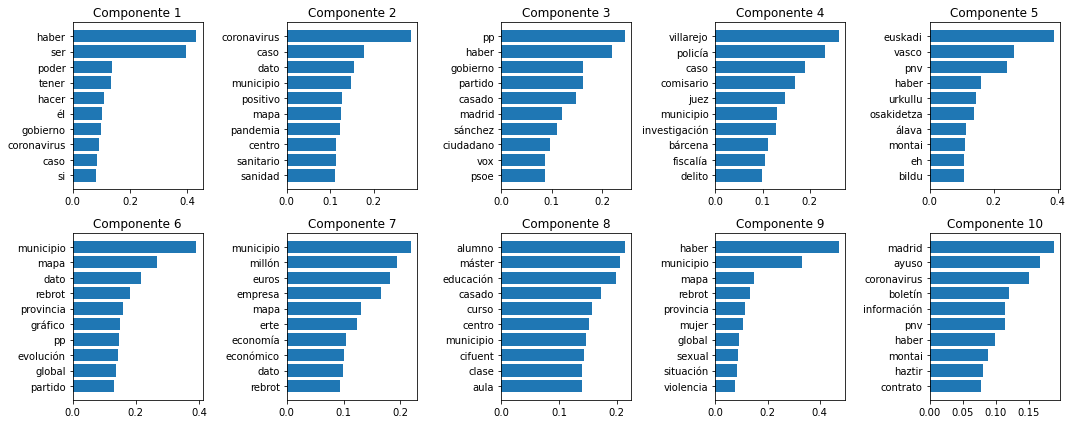

In [11]:
# Crear una figura y un arreglo de ejes
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Aplanar el arreglo de ejes para iterar sobre él
axes = axes.flatten()

# Iterar sobre las componentes
for i in range(10):
    # Seleccionar los 10 términos con mayor peso en la componente i usando iloc
    top_terms = term_topic_matrix.iloc[:, i].sort_values(ascending=True).tail(10) #invertido para plotear de forma descendente segun su valor.
    
    # Obtener los nombres y los pesos de los términos
    names = top_terms.index
    values = top_terms.values
    
    # Hacer un gráfico de barras horizontal con los nombres y los pesos de los términos en el eje i
    axes[i].barh(names, values)
    
    # Añadir un título al eje i con el número de la componente
    axes[i].set_title(f'Componente {i+1}')

# Ajustar el espacio entre los ejes
plt.tight_layout()

# Mostrar la figura
plt.show()

## ¿Cómo describirías cada uno de dichos conceptos latentes?

Los conceptos latentes dependen de una representación vectorial para representar los términos en una semántica latente, en donde el contexto determina la similitud entre los elementos. Por ejemplo, el primer componente tiene fuerte participación de los verbos haber y ser, el componente 4 de términos relacionados a la ley, el concepto 5 de gentilicios españoles, el 8 de educación, etc. Básicamente estos componentes son las distintas agrupaciones posibles para representar las semánticas disponibles en los textos.

# 9. Con base a los resultados del ejercicio anterior, ¿cuántos tópicos o conceptos latentes identificas con claridad? ¿Cómo os describirías, es decir, de qué temáticas estarían hablando

Se logran describir seis conceptos latentes claramente marcados. En el primero, se tiene el concepto de 'ser'; en el cuarto, términos relacionados a la policía y la autoridad; en el quinto, gentilicios españoles; en el sexto, conceptos de mapas y geografías; en el séptimo, términos económicos y de monedas; en el octavo, conceptos de educación.

# 10. La librería de código abierto Gensim, incluye la implementación de la técnica LSI

Investiga la documentación de este modelo LSI en Gensim y aplica dicha técnica a tu conjunto de
datos. En particular, obtener los modelos de 2 a 10 temas/tópicos y para cada uno de ellos obtener
su valor (score) de coherencia. Con base a dichos valores, ¿qué cantidad de tópicos sería el
adecuado? ¿Coincide con lo que obtuviste previamente, usando la técnica SVD de manera directa?

In [12]:
from gensim.models import LsiModel, CoherenceModel
from gensim.corpora import Dictionary

common_dictionary = Dictionary(preprocessed_tokens)
common_dictionary.filter_extremes(no_below=10, no_above=0.5)

common_corpus = [common_dictionary.doc2bow(text) for text in preprocessed_tokens]

c:\Users\matth\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [13]:
# Crear una lista vacía para guardar los modelos y los valores de coherencia
models = []
coherences = []

# Iterar sobre el rango de 2 a 10 temas
for num_topics in tqdm(range(2, 11)):
    # Crear un objeto LsiModel con el corpus, el diccionario y el número de temas
    lsi_model = LsiModel(corpus=common_corpus, id2word=common_dictionary, num_topics=num_topics)
    
    # Crear un objeto CoherenceModel con el modelo LSI, el corpus, el diccionario y el tipo de coherencia
    coherence_model = CoherenceModel(model=lsi_model, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v', texts=preprocessed_tokens)
    
    # Obtener el valor de coherencia del modelo
    coherence = coherence_model.get_coherence()
    
    # Añadir el modelo y el valor de coherencia a la lista
    models.append(lsi_model)
    coherences.append(coherence)

  0%|          | 0/9 [00:00<?, ?it/s]

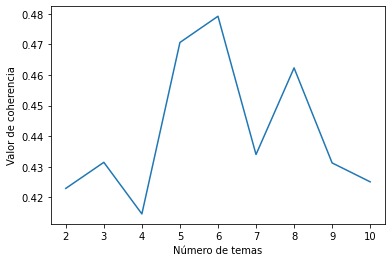

In [14]:
fig, ax = plt.subplots()

ax.plot(range(2, 11), coherences)

ax.set_xlabel('Número de temas')
ax.set_ylabel('Valor de coherencia')

plt.show()

# 11. Gensim para implementar ahora la técnica de LDA

In [15]:
from gensim.models import LdaMulticore, CoherenceModel

# Crear una lista vacía para guardar los modelos y los valores de coherencia
models = []
coherences = []

# Iterar sobre el rango de 2 a 10 temas
for num_topics in tqdm(range(2, 11)):
    # Crear un objeto LdaMulticore con el corpus, el diccionario y el número de temas
    lda_model = LdaMulticore(corpus=common_corpus, id2word=common_dictionary, num_topics=num_topics, workers=20)
    
    # Crear un objeto CoherenceModel con el modelo LDA, el corpus, el diccionario, el tipo de coherencia y los textos
    coherence_model = CoherenceModel(model=lda_model, corpus=common_corpus, dictionary=common_dictionary, coherence='c_v', texts=preprocessed_tokens)
    
    # Obtener el valor de coherencia del modelo
    coherence = coherence_model.get_coherence()
    
    # Añadir el modelo y el valor de coherencia a la lista
    models.append(lda_model)
    coherences.append(coherence)

  0%|          | 0/9 [00:00<?, ?it/s]

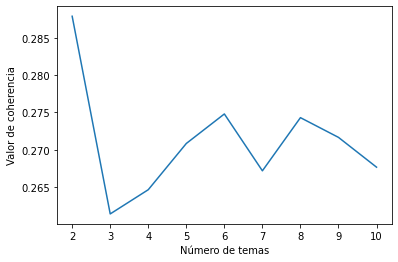

In [16]:
fig, ax = plt.subplots()

ax.plot(range(2, 11), coherences)

ax.set_xlabel('Número de temas')
ax.set_ylabel('Valor de coherencia')

plt.show()

# 12. Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias? ¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a considerar?

La cantidad de temas más adecuada según LDA, basándose exclusivamente en el valor de coherencia es 2. Sin embargo, esto presentaría un problema al ser muy limitado el espacio de representación semántica disponible para los términos, por lo que el siguiente valor, seis temas, es el más adecuado para LDA. Comparando LDA y LSI, vemos que LDA coincide con este resultado. Al realizar tanto el análisis de los componentes latentes y visualizar la composición de estos componentes, así como al analizar los resultados obtenidos con el método LSI, es posible ver cómo seis temas es la cantidad más conveniente. 

# 13. Visualizacion con  pyLDAvis

In [17]:
!pip install pyLDAvis
!pip install pyLDAvis.gensim_models


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement pyLDAvis.gensim_models (from versions: none)
ERROR: No matching distribution found for pyLDAvis.gensim_models

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import pyLDAvis
import pyLDAvis.gensim_models

# Crear una variable con el mejor modelo de LDA (por ejemplo, el que tiene 3 temas)
best_model = models[4]

# Preparar los datos para la visualización
vis_data = pyLDAvis.gensim_models.prepare(best_model, common_corpus, common_dictionary)

# Mostrar la visualización
pyLDAvis.display(vis_data)

c:\Users\matth\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


# 14. Conclusiones

Esta actividad destaca la utilidad del modelado de temas como una forma de analizar y entender grandes conjuntos de datos de texto. Utilizamos varias técnicas, incluyendo la Indexación Semántica Latente (LSI), la Descomposición de Valores Singulares Truncada (SVD) y la Asignación de Dirichlet Latente (LDA), cada una de las cuales aportó diferentes perspectivas sobre nuestros datos. Además, utilizando la librería pyLDAvis para visualizar nuestros modelos de temas, pudimos explorar de manera más profunda e interactiva las relaciones entre los distintos temas y los términos que los componen.

En cuanto a los hallazgos, se encontró lo siguiente: 

* Este ejercicio se trata de una clasificación no supervisada, pues no se tiene una clasificación previa de los datos a utilizar con respecto a la distribución y demarcación de los temas. 

* La utilización de componentes principales permitió visualizar los términos incluidos en cada componente semántico.

* Con la técnica LSI, evaluando el valor de coherencia, se encontró que el número óptimo de temas a utilizar es seis.

* Con la técnica LDA, evaluando el valor de coherencia, se encontró que el número óptimo de temas a utilizar es dos, seguido de seis. Al considerar que dos componentes semánticos serían muy generales para representar los temas, se considera seis como el número de temas más óptimo para esta solución.

- A través de la exploración de la composición y las relaciones entre los tópicos identificados, apoyada por la librería PyLDAvis, se encontró que el modelo con seis temas semánticos cuenta con alta distribución marginal de términos en cada uno de los temas. Esto es conveniente, pues indica que existe alta separabilidad y definición entre ellos.



En resumen, esta actividad demostró que la combinación de diferentes técnicas y herramientas en el modelado de temas puede proporcionar una visión rica y matizada de los patrones en un conjunto de datos de texto. Al estar dispuestos a experimentar y adaptar nuestras técnicas a los datos específicos con los que estamos trabajando, podemos obtener una comprensión más profunda y valiosa de nuestros datos.